In [3]:
!pip install gym
!pip install torch
!pip install numpy
!pip install matplotlib  # For plotting (optional)

Episode 10/500, Average Reward: 16.30
Episode 20/500, Average Reward: 19.00
Episode 30/500, Average Reward: 16.80
Episode 40/500, Average Reward: 46.00
Episode 50/500, Average Reward: 83.10
Episode 60/500, Average Reward: 90.40
Episode 70/500, Average Reward: 137.70
Episode 80/500, Average Reward: 155.80
Episode 90/500, Average Reward: 158.20
Episode 100/500, Average Reward: 150.10
Episode 110/500, Average Reward: 160.40
Episode 120/500, Average Reward: 210.50
Episode 130/500, Average Reward: 261.10
Episode 140/500, Average Reward: 247.00
Episode 150/500, Average Reward: 210.70
Episode 160/500, Average Reward: 196.00
Episode 170/500, Average Reward: 242.40
Episode 180/500, Average Reward: 234.10
Episode 190/500, Average Reward: 233.20
Episode 200/500, Average Reward: 353.70
Episode 210/500, Average Reward: 220.40
Episode 220/500, Average Reward: 190.90
Episode 230/500, Average Reward: 154.10
Episode 240/500, Average Reward: 156.10
Episode 250/500, Average Reward: 176.10
Episode 260/500

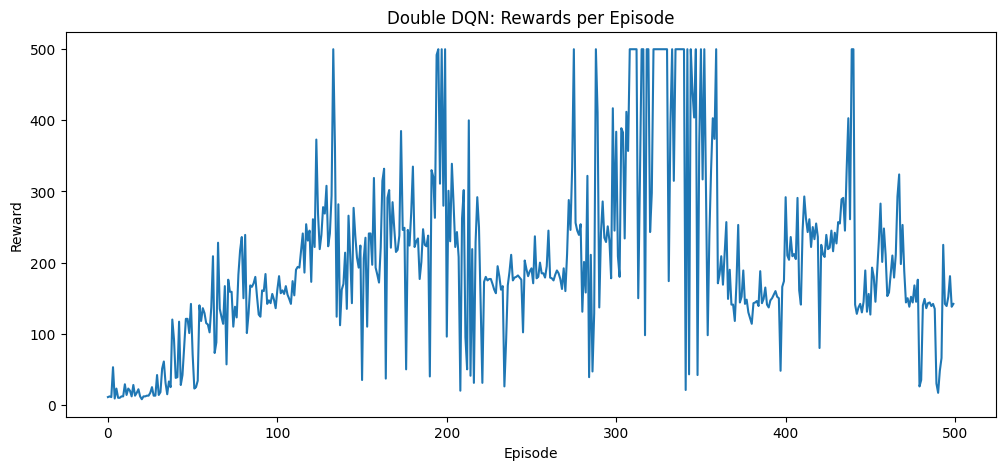

Episode 1: Total Reward: 124.0
Episode 2: Total Reward: 127.0
Episode 3: Total Reward: 128.0
Episode 4: Total Reward: 123.0
Episode 5: Total Reward: 122.0
Episode 6: Total Reward: 129.0
Episode 7: Total Reward: 125.0
Episode 8: Total Reward: 125.0
Episode 9: Total Reward: 127.0
Episode 10: Total Reward: 129.0
Average Reward over 10 episodes: 125.9


In [6]:
import gym
import math
import random
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the DQN network
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

# Replay Memory
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Double DQN Agent
class DoubleDQNAgent:
    def __init__(self, state_size, action_size, device):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device

        # Initialize policy and target networks
        self.policy_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Replay memory
        self.memory = ReplayMemory(10000)
        self.batch_size = 64
        self.gamma = 0.99

        # Epsilon parameters for ε-greedy policy
        self.epsilon_start = 1.0
        self.epsilon_end = 0.05
        self.epsilon_decay = 500

        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-3)

        # Step counter and target network update frequency
        self.steps_done = 0
        self.target_update = 10  # Update target network every 10 episodes

    def select_action(self, state):
        epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                  math.exp(-1. * self.steps_done / self.epsilon_decay)
        self.steps_done += 1
        if random.random() < epsilon:
            return random.randrange(self.action_size)
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state)
                return q_values.max(1)[1].item()

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        # Convert to tensors
        state_batch = torch.FloatTensor(batch.state).to(self.device)
        action_batch = torch.LongTensor(batch.action).unsqueeze(1).to(self.device)
        reward_batch = torch.FloatTensor(batch.reward).unsqueeze(1).to(self.device)
        next_state_batch = torch.FloatTensor(batch.next_state).to(self.device)
        done_batch = torch.FloatTensor(batch.done).unsqueeze(1).to(self.device)

        # Compute current Q values
        current_q = self.policy_net(state_batch).gather(1, action_batch)

        # Double DQN: Select actions using policy network, evaluate using target network
        with torch.no_grad():
            # Action selection using policy network
            next_actions = self.policy_net(next_state_batch).max(1)[1].unsqueeze(1)
            # Action evaluation using target network
            next_q = self.target_net(next_state_batch).gather(1, next_actions)
            expected_q = reward_batch + (self.gamma * next_q * (1 - done_batch))

        # Compute loss
        loss = F.mse_loss(current_q, expected_q)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Training function
def train_double_dqn(env, agent, num_episodes):
    rewards_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            # Store the transition in memory
            agent.memory.push(state, action, reward, next_state, done)

            state = next_state
            agent.optimize_model()

        rewards_per_episode.append(total_reward)

        # Update the target network
        if episode % agent.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

        # Print progress every 10 episodes
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(rewards_per_episode[-10:])
            print(f"Episode {episode+1}/{num_episodes}, Average Reward: {avg_reward:.2f}")

    print("Training complete")
    return rewards_per_episode

# Evaluation function
def evaluate_agent(env, agent, num_episodes=10):
    total_rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
                q_values = agent.policy_net(state_tensor)
                action = q_values.max(1)[1].item()
            state, reward, done, _ = env.step(action)
            total_reward += reward
        total_rewards.append(total_reward)
        print(f"Episode {episode+1}: Total Reward: {total_reward}")
    avg_reward = np.mean(total_rewards)
    print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return total_rewards

# Main function
def main():
    env = gym.make('CartPole-v1')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DoubleDQNAgent(state_size, action_size, device)

    num_episodes = 500
    rewards = train_double_dqn(env, agent, num_episodes)

    # Plot rewards
    plt.figure(figsize=(12,5))
    plt.title("Double DQN: Rewards per Episode")
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()

    # Evaluate the agent
    evaluate_agent(env, agent, num_episodes=10)

    env.close()

if __name__ == "__main__":
    main()
